In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime , timedelta
import calendar
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



WEATHER DATA
---


- **Read pre-processed weather hourly data downloaded from wetterdienst library (DWD) from drive**
- **Convert date column into datetime**
- **Drop station column for climate data and aggregate over date with hour timestamp**

---



In [ ]:
climate_sunshine=pd.read_csv('/content/drive/MyDrive/Master Thesis/Script/Datasets/Climate/sunshine_data.csv')
climate_cloud=pd.read_csv('/content/drive/MyDrive/Master Thesis/Script/Datasets/Climate/cloud_cover_total.csv')
climate_wind=pd.read_csv('/content/drive/MyDrive/Master Thesis/Script/Datasets/Climate/wind_speed_data.csv')
climate_humidity=pd.read_csv('/content/drive/MyDrive/Master Thesis/Script/Datasets/Climate/humidity.csv')

# Step 1: Convert to datetime while preserving timezone
climate_sunshine['date'] = pd.to_datetime(climate_sunshine['date'], utc=True)
climate_cloud['date'] = pd.to_datetime(climate_cloud['date'], utc=True)
climate_wind['date'] = pd.to_datetime(climate_wind['date'], utc=True)
climate_humidity['date'] = pd.to_datetime(climate_humidity['date'], utc=True)

# Step 2: Convert back to naive datetime (remove timezone)
climate_sunshine['date'] = climate_sunshine['date'].dt.tz_localize(None)
climate_cloud['date'] = climate_cloud['date'].dt.tz_localize(None)
climate_wind['date'] = climate_wind['date'].dt.tz_localize(None)
climate_humidity['date'] = climate_humidity['date'].dt.tz_localize(None)

# Ensure the 'date' column is in datetime format
climate_sunshine['date'] = pd.to_datetime(climate_sunshine['date'])
climate_cloud['date'] = pd.to_datetime(climate_cloud['date'])
climate_humidity['date'] = pd.to_datetime(climate_humidity['date'])
climate_wind['date'] = pd.to_datetime(climate_wind['date'])

# Group by hourly timestamp (ignoring 'state') and calculate the average sunshine duration
result_sunshine = climate_sunshine.groupby('date').agg({'sunshine_duration': 'mean'}).reset_index()
result_cloud = climate_cloud.groupby('date').agg({'cloud_cover_total': 'mean'}).reset_index()
result_wind= climate_wind.groupby('date').agg({'wind_speed': 'mean'}).reset_index()
result_humidity = climate_humidity.groupby('date').agg({'humidity': 'mean'}).reset_index()

# Rename columns for clarity
result_sunshine.columns = ['date', 'average_sunshine_duration']
result_cloud.columns = ['date', 'average_cloud']
result_wind.columns = ['date', 'average_wind']
result_humidity.columns = ['date', 'average_humidity']

# Generate a date range from 2020-01-01 00:00:00 to 2024-09-29 23:00:00 with an hourly frequency
date_range = pd.date_range(start="2020-01-01 00:00:00", end="2024-09-29 23:00:00", freq='h')

# Create a DataFrame with this date range
df = pd.DataFrame(date_range, columns=['date'])
#All downloaded data is till 30th Dec (31st Dec 00:00:00), hence excluding this date for now - as it is time taking to download data again
df = df[~((df['date'].dt.month == 12) & (df['date'].dt.day == 31))]

# Merge additional dataframes with the main dataframe `df`
df_climate = df.merge(result_cloud, on='date', how='left') \
              .merge(result_wind, on='date', how='left') \
              .merge(result_sunshine, on='date', how='left')\
              .merge(result_humidity, on='date', how='left')

# Display the merged dataframe
print(df_climate.head())

                 date  average_cloud  average_wind  average_sunshine_duration  \
0 2020-01-01 00:00:00      53.619397      2.620896                        0.0   
1 2020-01-01 01:00:00      58.767561      2.795573                        0.0   
2 2020-01-01 02:00:00      54.269978      2.794899                        0.0   
3 2020-01-01 03:00:00      49.313216      2.671819                        0.0   
4 2020-01-01 04:00:00      49.544690      2.701942                        0.0   

   average_humidity  
0         91.549898  
1         92.065173  
2         92.171079  
3         92.448065  
4         92.464358  


<Axes: >

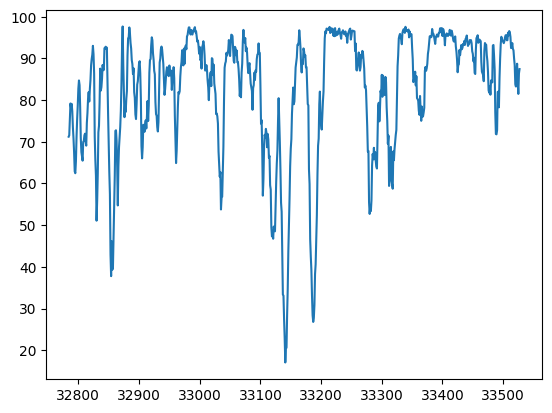

In [ ]:
df_climate[(df_climate.date.dt.month == 10) & (df_climate.date.dt.year == 2023)].average_cloud.plot()

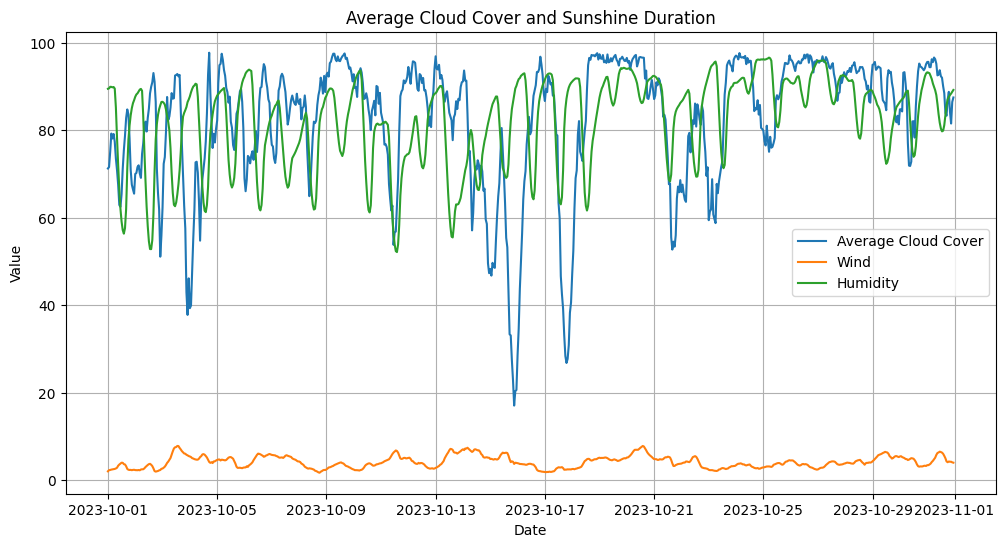

In [ ]:
df_oct_2023 = df_climate[(df_climate.date.dt.month == 10) & (df_climate.date.dt.year == 2023)]
plt.figure(figsize=(12, 6))
plt.plot(df_oct_2023['date'], df_oct_2023['average_cloud'], label='Average Cloud Cover')
#plt.plot(df_oct_2023['date'], df_oct_2023['average_sunshine_duration'], label='Average Sunshine Duration')
plt.plot(df_oct_2023['date'], df_oct_2023['average_wind'], label='Wind')
plt.plot(df_oct_2023['date'], df_oct_2023['average_humidity'], label='Humidity')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Average Cloud Cover and Sunshine Duration')
plt.legend()
plt.grid(True)
plt.show()

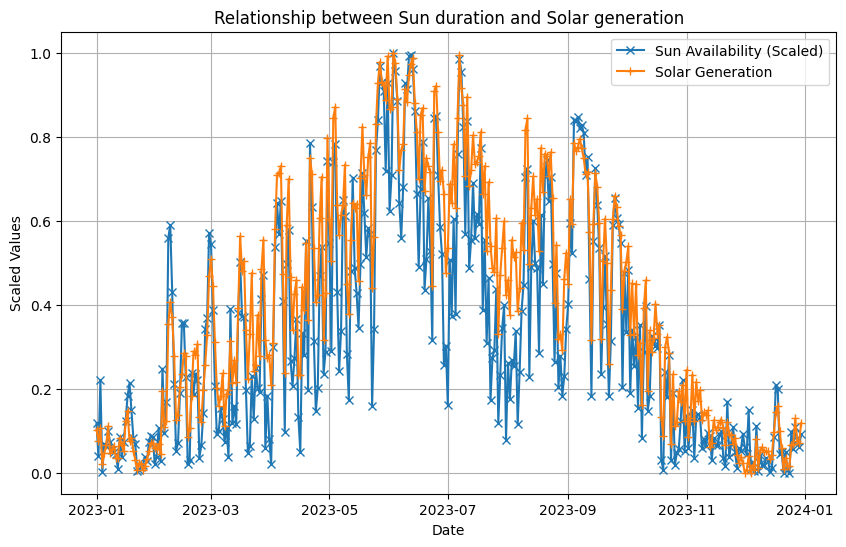

In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#df_2023 = df_final_merged[df_final_merged.index.year == 2023].copy(True)
#df_2023.set_index('date', inplace=True
df_2023_daily = df_2023.resample('D').mean()
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_2023_daily[['average_sunshine_duration', 'Solar','Wind Offshore','Wind Onshore','average_wind']]),
                         columns=['Sun Availability', 'Solar Generation','Offshore Wind','Onshore Wind',' Wind Speed'], index=df_2023_daily.index)
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_scaled['Sun Availability'], label='Sun Availability (Scaled)', marker='x')
#plt.plot(df_scaled['average_cloud'], label='Cloud Cover',marker='o')
plt.plot(df_scaled[ 'Solar Generation'], label= 'Solar Generation',marker='+')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.title('Relationship between Sun duration and Solar generation')
plt.legend()
plt.grid(True)
plt.show()


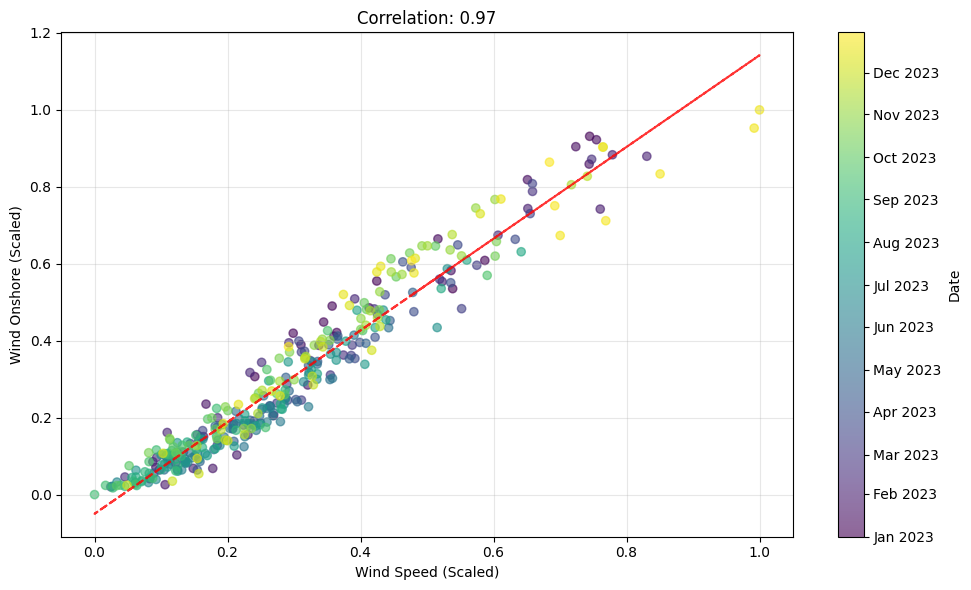

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming df_scaled is already created as in your original code
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Create the plot
plt.figure(figsize=(10, 6))

df_scaled = pd.DataFrame(scaler.fit_transform(df_2023_daily[['average_sunshine_duration', 'Solar','Wind Offshore','Wind Onshore','average_wind']]),
                         columns=['Sun Availability', 'Solar Generation','Offshore Wind','Onshore Wind','Wind Speed'], index=df_2023_daily.index)
# Convert dates to numerical values
date_nums = mdates.date2num(df_scaled.index)
# Scatter plot with color gradient
scatter = plt.scatter(df_scaled['Wind Speed'],
                      df_scaled['Onshore Wind'],
                      c=date_nums,
                      cmap='viridis',
                      alpha=0.6)

# Add trend line
z = np.polyfit(df_scaled['Wind Speed'], df_scaled['Onshore Wind'], 1)
p = np.poly1d(z)
plt.plot(df_scaled['Wind Speed'], p(df_scaled['Wind Speed']), "r--", alpha=0.8)

# Set up the colorbar with date formatting
cbar = plt.colorbar(scatter)
cbar.set_label('Date')
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
cbar.ax.yaxis.set_major_locator(mdates.AutoDateLocator())
# Calculate correlation
correlation = stats.pearsonr(df_scaled['Wind Speed'], df_scaled['Onshore Wind'])[0]

plt.xlabel('Wind Speed (Scaled)')
plt.ylabel('Wind Onshore (Scaled)')
plt.title(f'Correlation: {correlation:.2f}')


# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


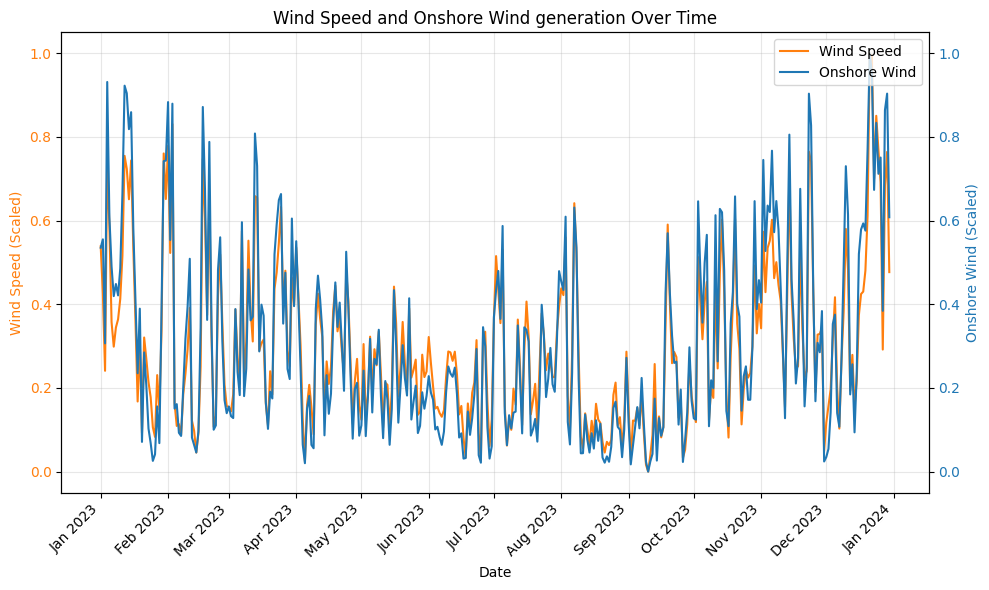

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df_scaled is already created as in your original code

fig, ax1 = plt.subplots(figsize=(10, 6))
#df_scaled['Wind Speed'], df_scaled['Onshore Wind']
# Plot Sun Availability
color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Wind Speed (Scaled)', color=color)
ax1.plot(df_scaled.index, df_scaled['Wind Speed'], color=color, label='Wind Speed')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Onshore Wind (Scaled)', color=color)
ax2.plot(df_scaled.index, df_scaled['Onshore Wind'], color=color, label='Onshore Wind')
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('Wind Speed and Onshore Wind generation Over Time')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Format x-axis to show dates nicely
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add grid for better readability
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


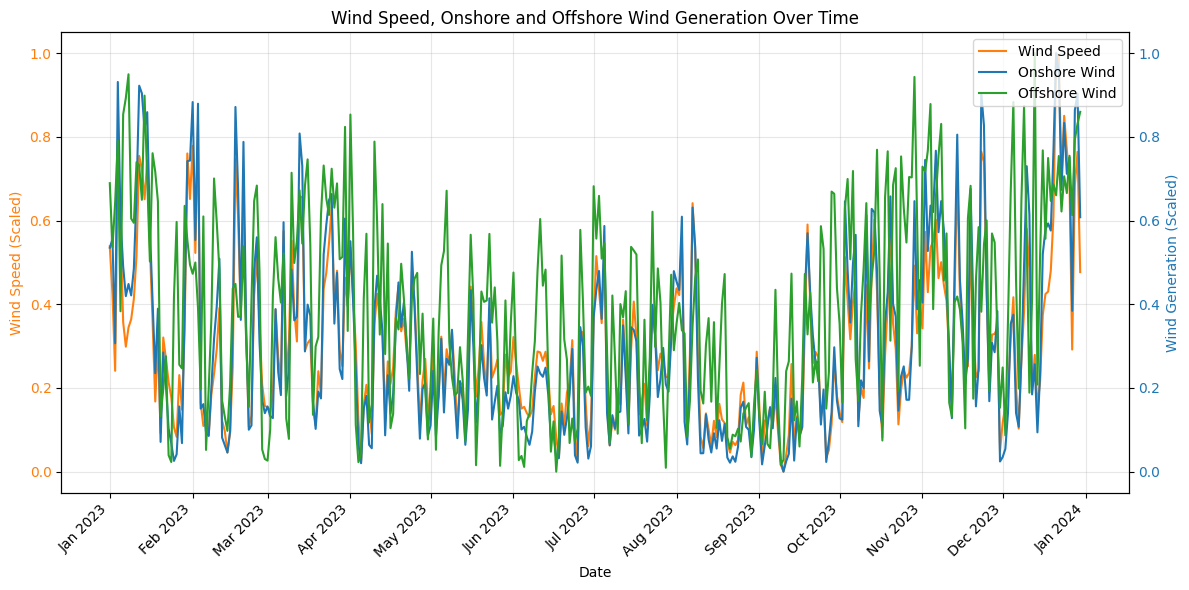

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df_scaled is already created as in your original code

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Wind Speed
color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Wind Speed (Scaled)', color=color)
ax1.plot(df_scaled.index, df_scaled['Wind Speed'], color=color, label='Wind Speed')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Onshore Wind
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Wind Generation (Scaled)', color=color)
ax2.plot(df_scaled.index, df_scaled['Onshore Wind'], color=color, label='Onshore Wind')
ax2.tick_params(axis='y', labelcolor=color)

# Add Offshore Wind to the second y-axis
color = 'tab:green'
ax2.plot(df_scaled.index, df_scaled['Offshore Wind'], color=color, label='Offshore Wind')

# Title and legend
plt.title('Wind Speed, Onshore and Offshore Wind Generation Over Time')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right", bbox_to_anchor=(1,1))

# Format x-axis to show dates nicely
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add grid for better readability
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ENTSOE DATA

---


- **Read pre-processed and merged load, generation and day-ahead price hourly data downloaded from ENTSOE library from drive**
- **Convert date column into datetime and bring the timezone from Berlin/Europe to UTC**


---



In [ ]:
entsoe_df=pd.read_csv( '/content/drive/MyDrive/Master Thesis/Script/Datasets/merged_df_hourly.csv')
merged_df = entsoe_df.copy()
merged_df['timestamp_europe'] = pd.to_datetime(merged_df['timestamp_europe'], utc=True)
merged_df['timestamp_europe'] = merged_df['timestamp_europe'].dt.tz_localize(None)
merged_df['timestamp_europe'] = merged_df['timestamp_europe'] + pd.Timedelta(hours=1)
merged_df.rename({'timestamp_europe':'date'},axis=1,inplace=True)

In [ ]:
merged_df.head(3)

,date,Brown Coal/Lignite,Gas,Hard Coal,Biomass,Oil,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,Other,Other RES,Waste,Wind Offshore,Wind Onshore,Solar,Load,Day-Ahead Price
0,2020-01-01 00:00:00,9317.00,6053.25,1961.75,4934.75,454.00,30.0,624.00,1330.00,307.00,8084.75,462.5,192.75,846.00,549.25,6058.50,0.0,43500.50,41.88
1,2020-01-01 01:00:00,9419.00,5681.00,1825.25,4916.75,454.00,30.0,669.50,1324.25,155.75,8089.50,461.0,192.00,826.25,1169.25,5862.50,0.0,42598.75,38.60
2,2020-01-01 02:00:00,9425.75,5493.50,1797.25,4918.00,454.25,30.0,2365.75,1319.25,109.50,8082.50,454.5,192.25,819.00,1665.50,5748.25,0.0,41463.75,36.55


In [ ]:
# Summary statistics
merged_df.describe()

,date,Brown Coal/Lignite,Gas,Hard Coal,Biomass,Oil,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,Other,Other RES,Waste,Wind Offshore,Wind Onshore,Solar,Load,Day-Ahead Price
count,41520,41520.000000,41519.000000,41520.000000,41519.000000,41520.000000,41520.000000,41520.000000,41519.000000,41519.000000,28751.000000,41520.000000,41520.000000,41519.000000,41520.000000,41519.000000,41519.000000,41520.000000,41520.000000
mean,2022-05-16 20:56:50.635838208,9921.353763,6226.252324,4982.029088,4462.670004,369.358634,22.630533,1140.079865,1551.581585,190.328406,5755.408968,266.977836,126.940065,750.498922,2826.293798,11815.129015,6305.885035,54624.078462,107.726451
min,2020-01-01 00:00:00,2493.750000,1221.250000,309.250000,3392.750000,174.000000,5.000000,0.000000,787.750000,3.250000,271.750000,111.000000,33.000000,131.750000,0.000000,106.250000,0.000000,30909.000000,-500.000000
25%,2021-03-09 11:45:00,6879.687500,3704.625000,2170.187500,4250.500000,304.000000,19.000000,188.000000,1277.500000,70.250000,3971.000000,187.500000,93.000000,687.500000,1047.937500,4317.875000,2.000000,46743.812500,40.610000
50%,2022-05-16 23:30:00,10635.250000,5661.750000,3917.125000,4488.750000,371.000000,23.000000,608.500000,1553.250000,132.750000,6471.500000,247.500000,125.750000,777.750000,2625.000000,8951.000000,250.250000,54596.250000,80.480000
75%,2023-07-24 11:15:00,12830.312500,8267.375000,7120.812500,4695.250000,404.000000,27.000000,1723.125000,1814.375000,252.500000,7759.375000,339.500000,157.000000,837.750000,4536.250000,17090.625000,10208.375000,62045.875000,130.840000
max,2024-09-29 23:00:00,17173.250000,17346.250000,16393.500000,5190.250000,1136.000000,34.000000,7957.000000,2353.500000,1091.000000,8204.750000,528.750000,211.000000,1015.000000,7633.250000,48205.750000,47104.000000,81319.500000,871.000000
std,NaN,3630.688928,3087.235429,3451.437264,309.123743,81.513939,5.181646,1297.487496,333.936462,169.426070,1965.579615,105.516502,39.335184,129.165927,1931.352548,9549.613320,9601.354169,9686.490702,105.976897


In [ ]:
# Check for missing values
missing_values = merged_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 date                                   0
Brown Coal/Lignite                     0
Gas                                    1
Hard Coal                              0
Biomass                                1
Oil                                    0
Geothermal                             0
Hydro Pumped Storage                   0
Hydro Run-of-river and poundage        1
Hydro Water Reservoir                  1
Nuclear                            12769
Other                                  0
Other RES                              0
Waste                                  1
Wind Offshore                          0
Wind Onshore                           1
Solar                                  1
Load                                   0
Day-Ahead Price                        0
dtype: int64


In [ ]:
merged_df=merged_df.drop(['Nuclear'],axis=1) # removal of nuclear column

# **Negative Day Ahead Prices**

In [ ]:
df_neg_prices = merged_df[merged_df['Day-Ahead Price'] < 0].copy(True)

In [ ]:
df_neg_prices.reset_index(inplace=True)

In [ ]:
df_neg_prices.drop('index',axis=1,inplace=True)

In [ ]:
df_neg_prices.groupby(df_neg_prices['date'].dt.year).size()

,0
date,
2020,298
2021,134
2022,47
2023,300
2024,413


In [ ]:
df_neg_prices[df_neg_prices['Day-Ahead Price']==df_neg_prices['Day-Ahead Price'].min()]

,date,Brown Coal/Lignite,Gas,Hard Coal,Biomass,Oil,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Other,Other RES,Waste,Wind Offshore,Wind Onshore,Solar,Load,Day-Ahead Price,year,color
576,2023-07-02 13:00:00,3186.5,2178.75,736.0,3863.25,384.0,16.25,16.75,1261.5,32.5,138.0,83.0,555.5,1915.0,14344.75,28258.5,43614.25,-500.0,2023,red


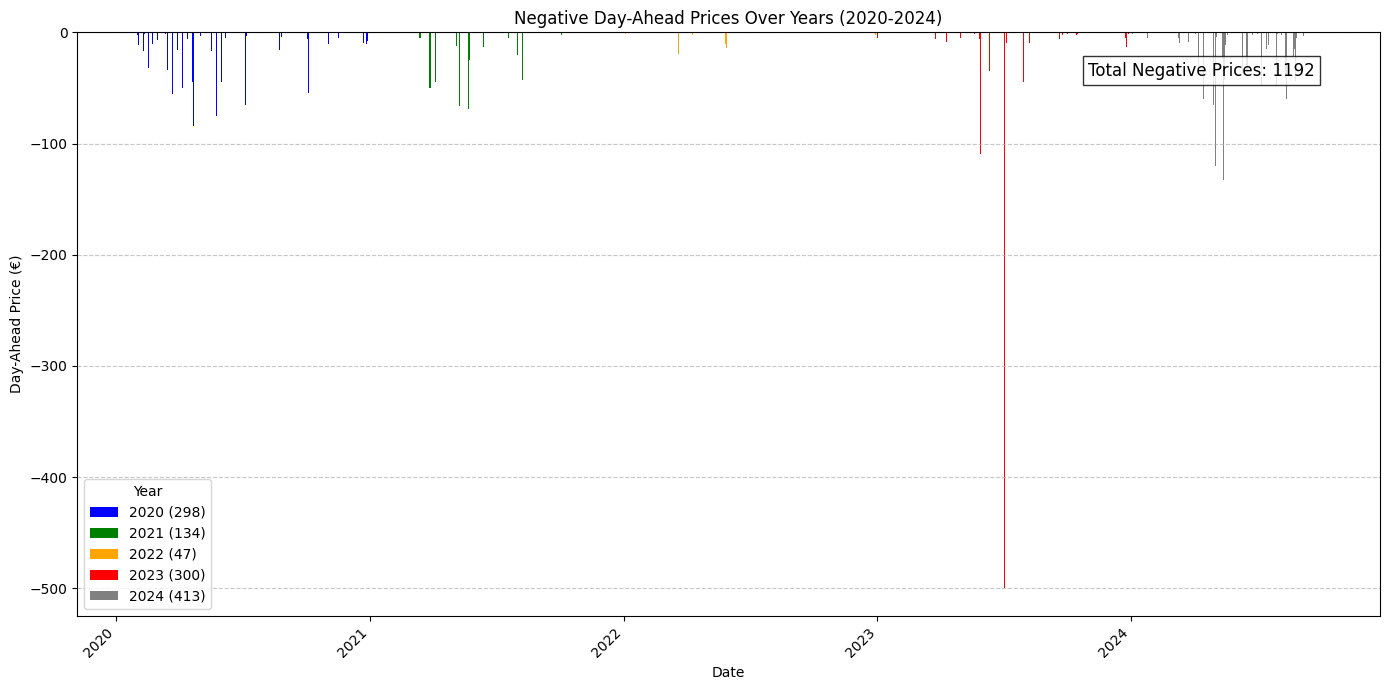

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_neg_prices['year'] = df_neg_prices['date'].dt.year

# Colors for different years
colors = {2020: 'blue', 2021: 'green', 2022: 'orange', 2023: 'red', 2024: 'gray'}
df_neg_prices['color'] = df_neg_prices['year'].map(colors)

# Visualization with different colors per year
plt.figure(figsize=(14, 7))
for year in df_neg_prices['year'].unique():
    subset = df_neg_prices[df_neg_prices['year'] == year]
    plt.bar(subset['date'], subset['Day-Ahead Price'], color=colors[year], label=f'{year} ({len(subset)})')


plt.xlabel('Date')
plt.ylabel('Day-Ahead Price (€)')
plt.title('Negative Day-Ahead Prices Over Years (2020-2024)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the total number of negative prices
total_neg_prices = len(df_neg_prices)
plt.text(0.95, 0.95, f'Total Negative Prices: {total_neg_prices}',
         horizontalalignment='right', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.legend(title='Year')
plt.tight_layout()
plt.show()


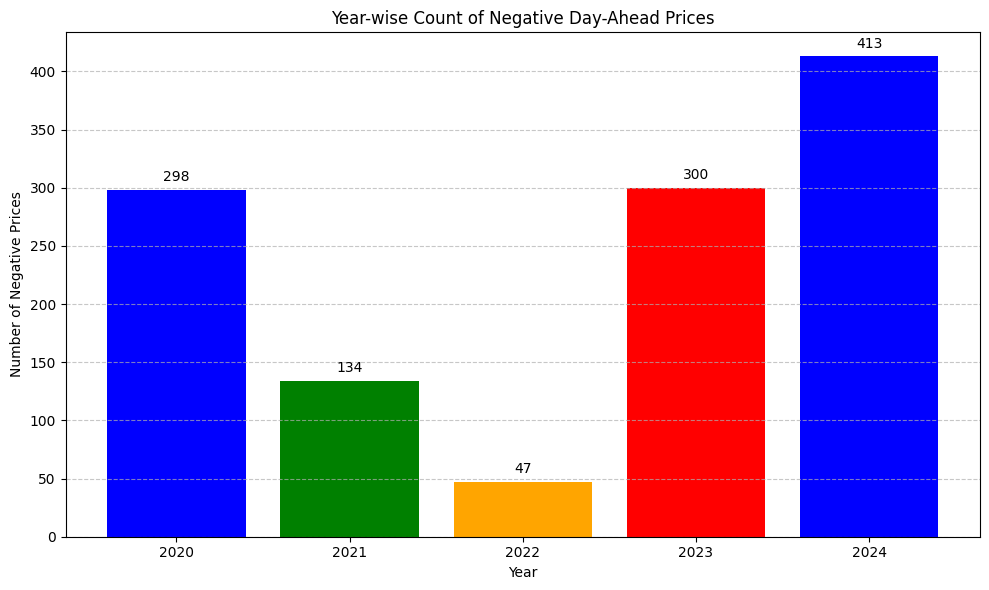

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_neg_prices['year'] = df_neg_prices['date'].dt.year

# Grouping by year to count negative prices
neg_price_counts = df_neg_prices.groupby('year').size()

# Colors for different years
colors = ['blue', 'green', 'orange', 'red']

# Stacked bar plot
plt.figure(figsize=(10, 6))
plt.bar(neg_price_counts.index, neg_price_counts.values, color=colors)

# Adding annotations for each bar
for i, count in enumerate(neg_price_counts.values):
    plt.text(neg_price_counts.index[i], count + 5, str(count), ha='center', va='bottom', fontsize=10)

plt.xlabel('Year')
plt.ylabel('Number of Negative Prices')
plt.title('Year-wise Count of Negative Day-Ahead Prices')
plt.xticks(neg_price_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# **Merge weather and power data**

In [ ]:
all_combined_P_C=df_climate.merge(merged_df, on='date', how='left')

In [ ]:
all_combined_P_C.isnull().sum()
#Null here are as data for each year is taken till 30-dec and 31st is missing, will start gathering again if time left.

,0
date,0
average_cloud,0
average_wind,0
average_sunshine_duration,0
average_humidity,0
Brown Coal/Lignite,0
Gas,1
Hard Coal,0
Biomass,1
Oil,0


In [ ]:
# Fill NaN values with the mean of each column
for col in all_combined_P_C.columns:
    if pd.api.types.is_numeric_dtype(all_combined_P_C[col]):  # Check if the column is numeric
        all_combined_P_C.fillna({col:all_combined_P_C[col].mean()}, inplace=True)

In [ ]:
all_combined_P_C.isnull().sum()

,0
date,0
average_cloud,0
average_wind,0
average_sunshine_duration,0
average_humidity,0
Brown Coal/Lignite,0
Gas,0
Hard Coal,0
Biomass,0
Oil,0


In [ ]:
all_combined_P_C.info()
all_combined_P_C.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41520 entries, 0 to 41519
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             41520 non-null  datetime64[ns]
 1   average_cloud                    41520 non-null  float64       
 2   average_wind                     41520 non-null  float64       
 3   average_sunshine_duration        41520 non-null  float64       
 4   average_humidity                 41520 non-null  float64       
 5   Brown Coal/Lignite               41520 non-null  float64       
 6   Gas                              41520 non-null  float64       
 7   Hard Coal                        41520 non-null  float64       
 8   Biomass                          41520 non-null  float64       
 9   Oil                              41520 non-null  float64       
 10  Geothermal                       41520 non-null  float64  

,date,average_cloud,average_wind,average_sunshine_duration,average_humidity,Brown Coal/Lignite,Gas,Hard Coal,Biomass,Oil,...,Hydro Run-of-river and poundage,Hydro Water Reservoir,Other,Other RES,Waste,Wind Offshore,Wind Onshore,Solar,Load,Day-Ahead Price
0,2020-01-01 00:00:00,53.619397,2.620896,0.0,91.549898,9317.0,6053.25,1961.75,4934.75,454.0,...,1330.00,307.00,462.5,192.75,846.00,549.25,6058.5,0.0,43500.50,41.88
1,2020-01-01 01:00:00,58.767561,2.795573,0.0,92.065173,9419.0,5681.00,1825.25,4916.75,454.0,...,1324.25,155.75,461.0,192.00,826.25,1169.25,5862.5,0.0,42598.75,38.60


# **Exploratory Data Analysis**


---



In [ ]:
columns = ['average_cloud', 'average_wind', 'average_sunshine_duration',
       'average_humidity','Brown Coal/Lignite', 'Gas', 'Hard Coal', 'Biomass', 'Oil', 'Geothermal', 'Hydro Pumped Storage',
           'Hydro Run-of-river and poundage', 'Hydro Water Reservoir','Other', 'Other RES', 'Waste',
           'Wind Offshore', 'Wind Onshore', 'Solar', 'Load']
# Compute correlation matrix
correlation_matrix = all_combined_P_C[columns + ['Day-Ahead Price']].corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


NameError: name 'all_combined_P_C' is not defined

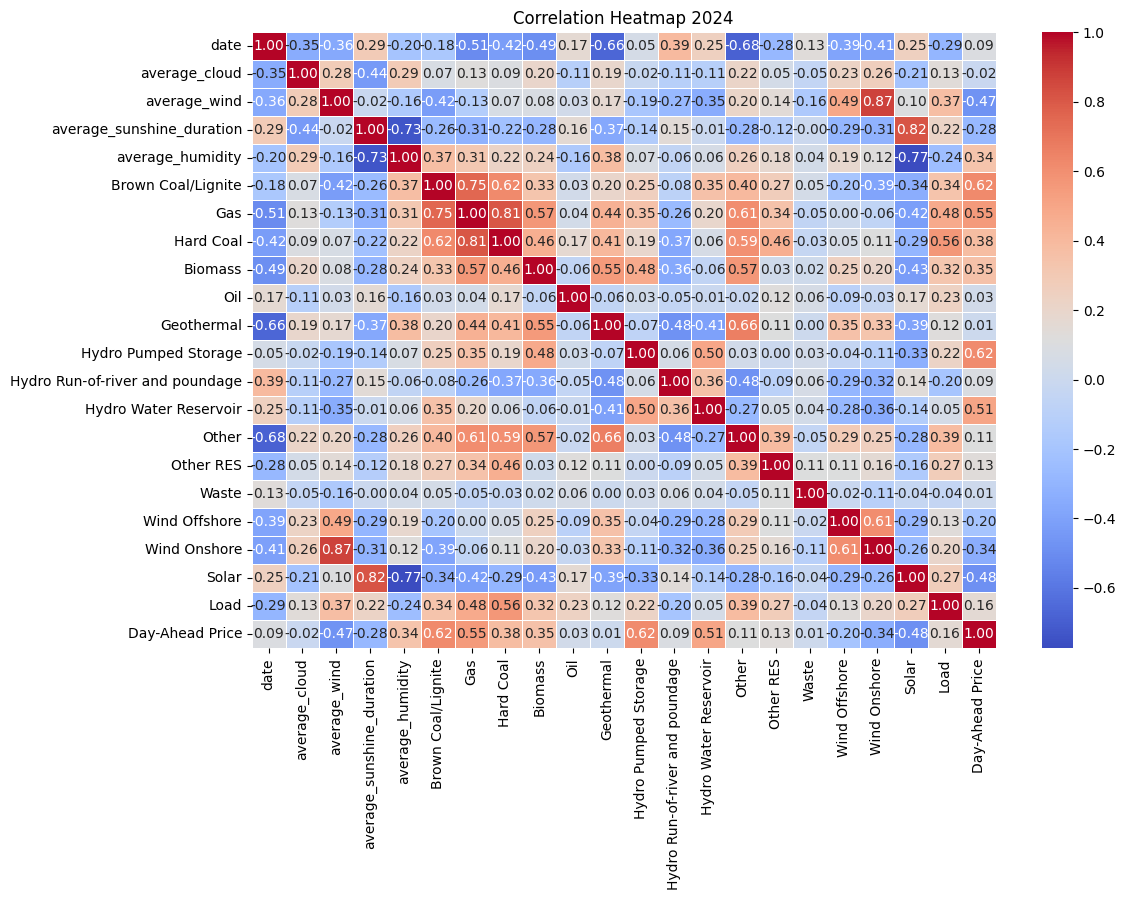

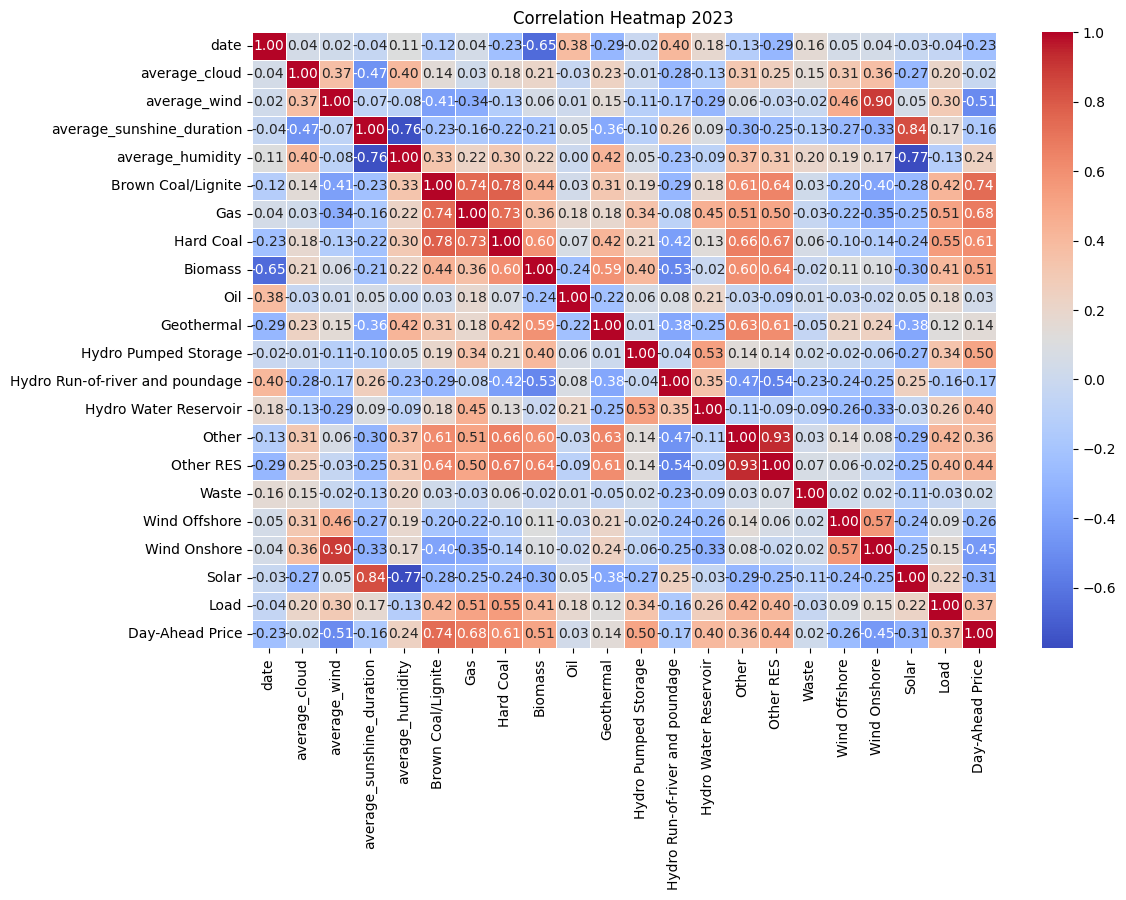

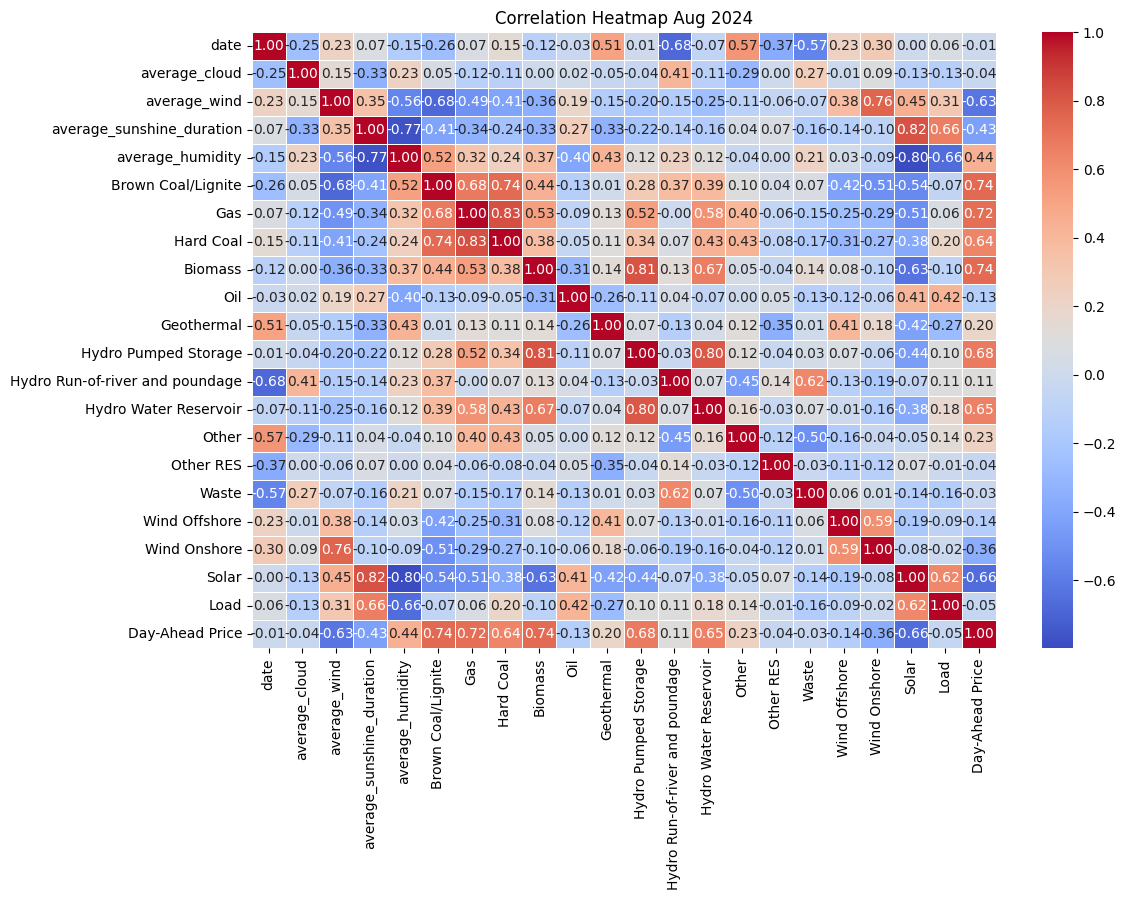

In [ ]:
df_2024 = all_combined_P_C[ (all_combined_P_C.date.dt.year == 2024)]
df_aug_2024 = all_combined_P_C[(all_combined_P_C.date.dt.month == 8) & (all_combined_P_C.date.dt.year == 2024)]
df_2023 = all_combined_P_C[(all_combined_P_C.date.dt.year == 2023)]
# Compute correlation matrix
# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df_2024.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap 2024')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df_2023.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap 2023')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df_aug_2024.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap Aug 2024')
plt.show()

**Hard Coal (0.58) and Brown Coal (0.48) have significant positive correlation with Day-Ahead Price among all the variables. Considering the weather variable, only 'Wind' has some negative correlation (-0.31) and others are near zero, hence no correlation.**


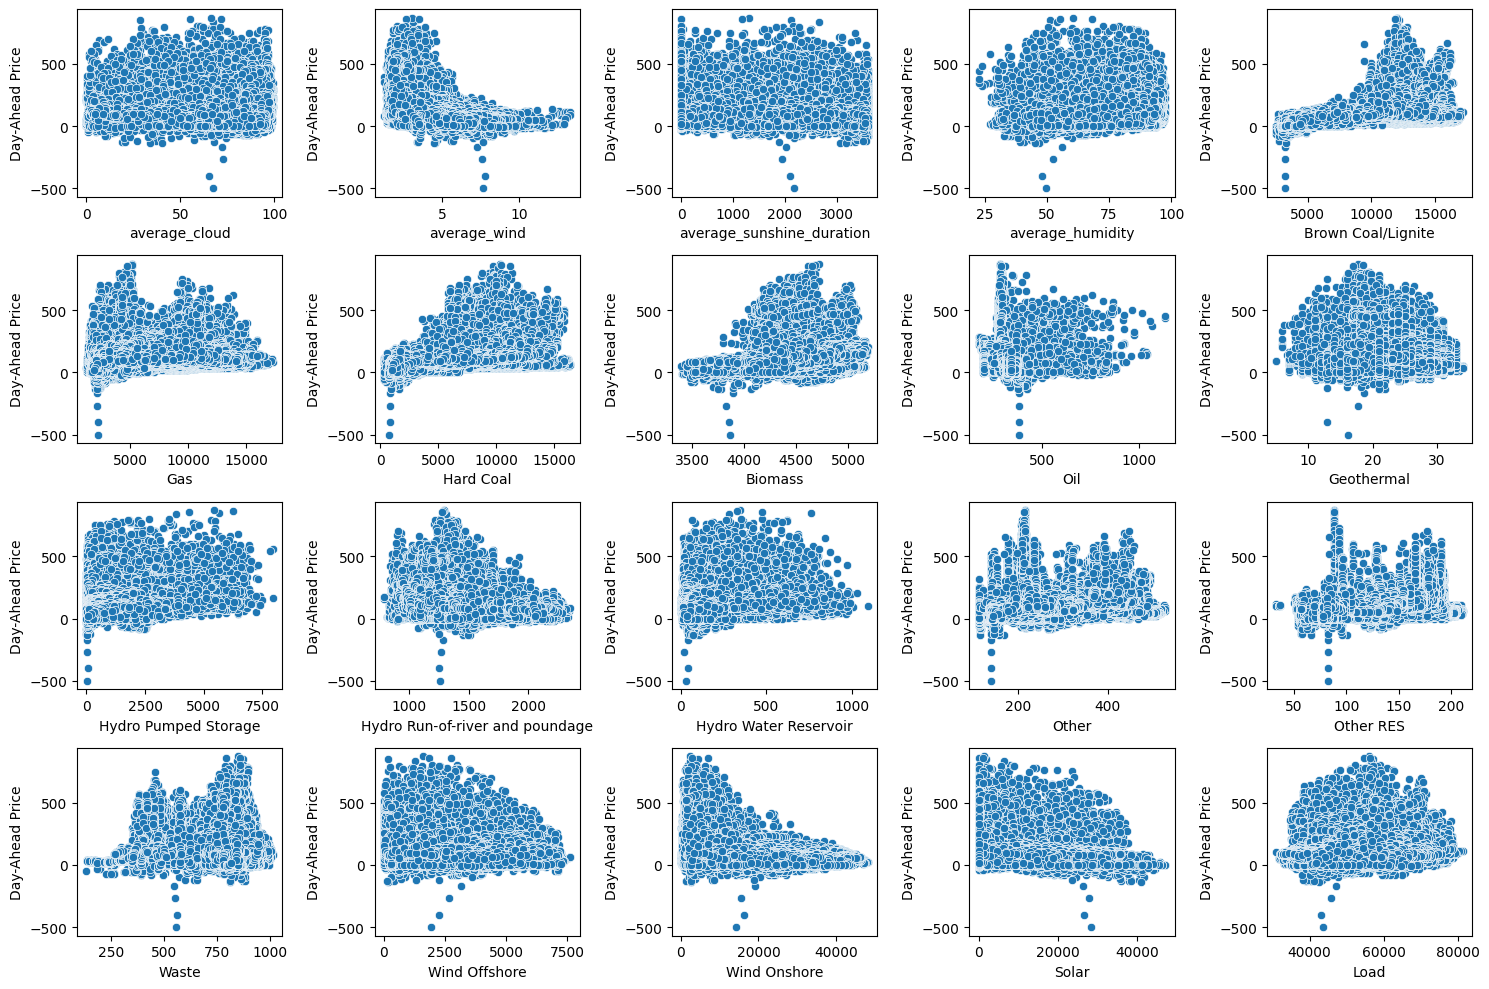

In [ ]:
# Scatter plot for Day-Ahead Price vs. other features
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns, 1):
    plt.subplot(4, 5, i)
    sns.scatterplot(x=all_combined_P_C[col], y=all_combined_P_C['Day-Ahead Price'])
plt.tight_layout()
plt.show()


The scatter plots provide insights into how individual features relate to the "Day-Ahead Price":

**Positive Relationships:** Features like "Solar" and "Wind Onshore" demonstrate a positive relationship with "Day-Ahead Price," suggesting that higher production from these sources coincides with higher prices.

**Negative Trends:** "average_cloud" and "Hydro Pumped Storage" show negative relationships, implying that increased values in these features might suppress prices.

**Non-Linear Patterns:** Some scatter plots, such as those for "Gas" and "Hard Coal," indicate non-linear relationships, which may require advanced modeling techniques to fully capture their impact on pricing.

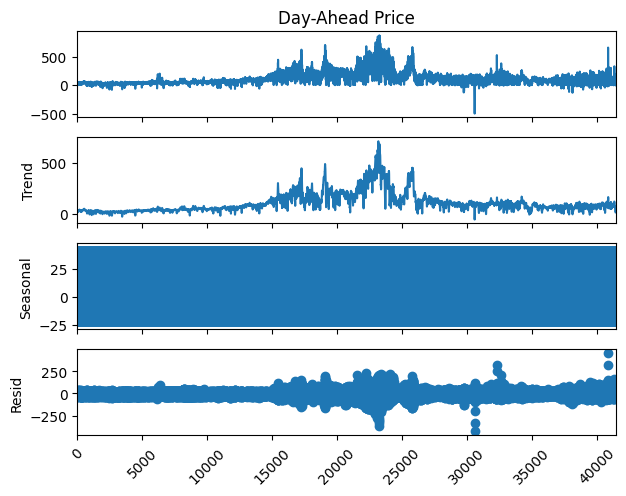

In [ ]:
# Decompose Day-Ahead Price time series
decomposition = seasonal_decompose(all_combined_P_C['Day-Ahead Price'], model='additive', period=24)  # 24-hour period
decomposition.plot()
plt.xticks(rotation=45)
plt.show()


***Stationary Analysis***

In [ ]:
result = adfuller(all_combined_P_C['Day-Ahead Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])


ADF Statistic: -7.636993261906268
p-value: 1.9405606485554177e-11
Critical Values: {'1%': -3.430507720067512, '5%': -2.8616097087144503, '10%': -2.566807103698281}


1. ADF Statistic
Value: -7.833643268498592
The ADF statistic is highly negative, which suggests that the time series is likely stationary. A more negative value means stronger evidence against the null hypothesis (that the data is non-stationary).
2. p-value
Value: 6.1974440254640255e-12 (very close to 0)
A p-value this small is much less than the common significance level of 0.05.
Interpretation: Reject the null hypothesis. The series is stationary with a very high level of confidence.

**Oulier Detection and Removal**

In [ ]:
columns

['average_cloud',
 'average_wind',
 'average_sunshine_duration',
 'average_humidity',
 'Brown Coal/Lignite',
 'Gas',
 'Hard Coal',
 'Biomass',
 'Oil',
 'Geothermal',
 'Hydro Pumped Storage',
 'Hydro Run-of-river and poundage',
 'Hydro Water Reservoir',
 'Other',
 'Other RES',
 'Waste',
 'Wind Offshore',
 'Wind Onshore',
 'Solar',
 'Load']

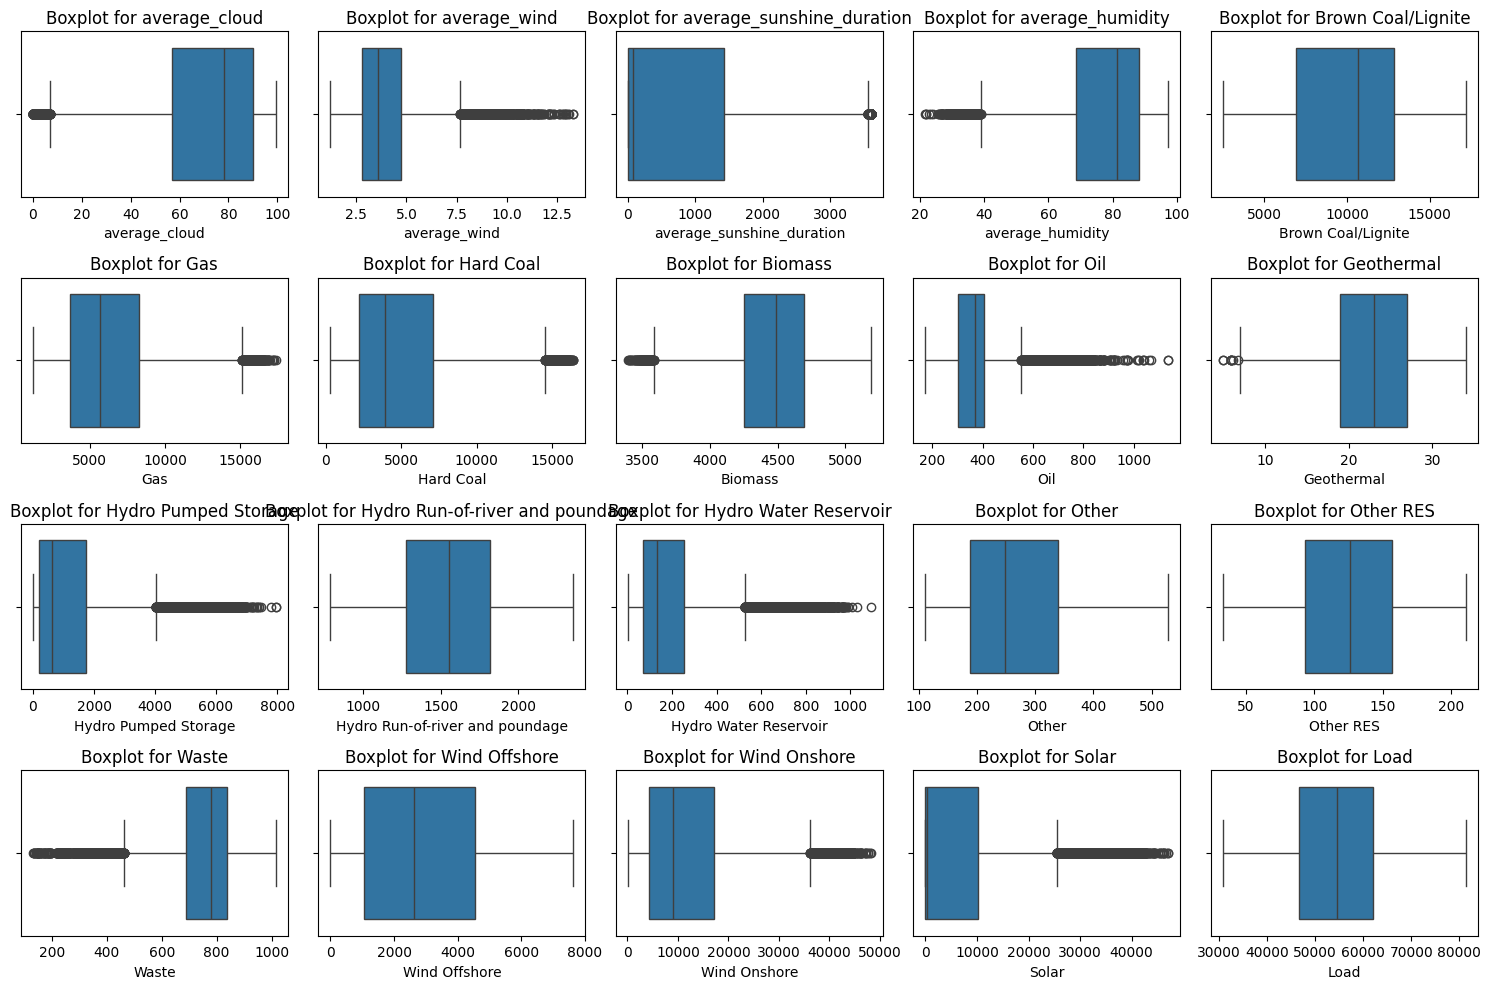

In [ ]:
# Visualize outliers using boxplot for each column
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns, 1):
    plt.subplot(4, 5, i)
    sns.boxplot(x=all_combined_P_C[col])
    plt.title(f'Boxplot for {col}')
plt.tight_layout()
plt.show()




---

# **Processing data :**
- Handling Outliers
- Skewness Analysis
-

---



In [ ]:
columns=columns+['Day-Ahead Price']

Number of outliers before replacement:
{'average_cloud': 0, 'average_wind': 536, 'average_sunshine_duration': 0, 'average_humidity': 186, 'Brown Coal/Lignite': 0, 'Gas': 129, 'Hard Coal': 84, 'Biomass': 74, 'Oil': 803, 'Geothermal': 36, 'Hydro Pumped Storage': 778, 'Hydro Run-of-river and poundage': 0, 'Hydro Water Reservoir': 830, 'Other': 0, 'Other RES': 0, 'Waste': 400, 'Wind Offshore': 0, 'Wind Onshore': 322, 'Solar': 500, 'Load': 0, 'Day-Ahead Price': 1024}

Number of outliers after replacement:
{'average_cloud': 0, 'average_wind': 0, 'average_sunshine_duration': 0, 'average_humidity': 0, 'Brown Coal/Lignite': 0, 'Gas': 0, 'Hard Coal': 0, 'Biomass': 0, 'Oil': 0, 'Geothermal': 36, 'Hydro Pumped Storage': 0, 'Hydro Run-of-river and poundage': 0, 'Hydro Water Reservoir': 0, 'Other': 0, 'Other RES': 0, 'Waste': 0, 'Wind Offshore': 0, 'Wind Onshore': 0, 'Solar': 0, 'Load': 0, 'Day-Ahead Price': 0}


<ipython-input-19-5e8da7e2b209>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
<ipython-input-19-5e8da7e2b209>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


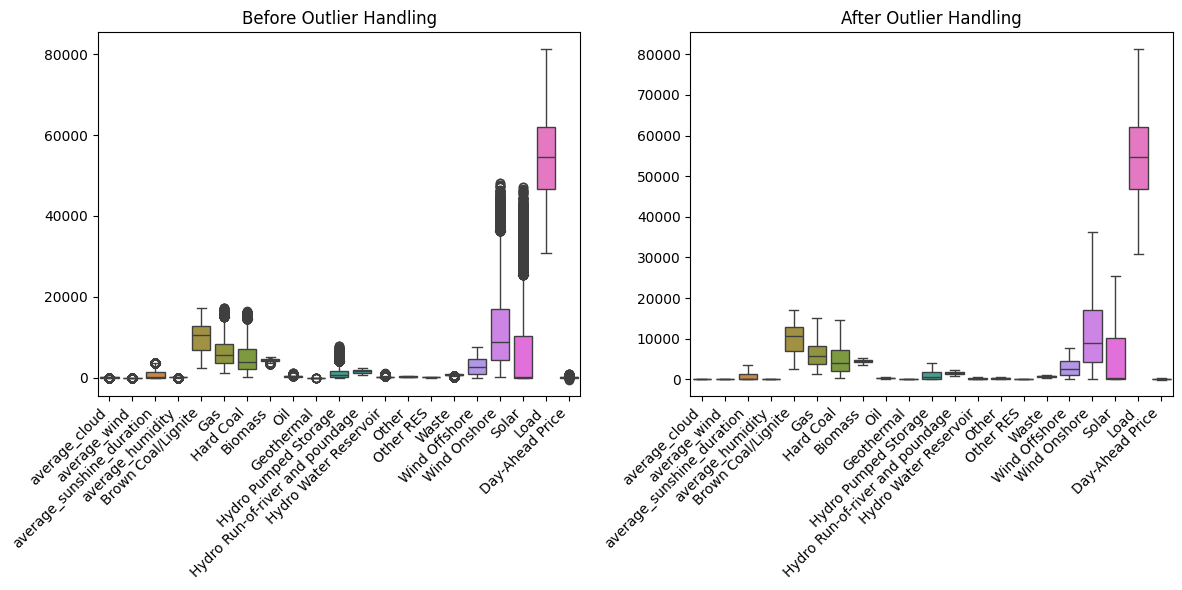

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Assuming 'all_combined_P_C' is your original dataframe and 'columns' is the list of columns to process

# Function to detect outliers based on Z-Score
def count_outliers(df, columns):
    outliers_zscore = {}
    for col in columns:
        z_scores = np.abs(stats.zscore(df[col]))
        outliers_zscore[col] = np.sum(z_scores > 3)  # Count outliers where Z-score > 3
    return outliers_zscore

# Function to replace outliers with capping
def replace_outliers_with_capping(df, columns):
    df_copy = df.copy()
    for col in columns:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_copy[col] = df_copy[col].clip(lower=lower_bound, upper=upper_bound)
    return df_copy

# Count outliers before replacement
outliers_before = count_outliers(all_combined_P_C, columns)
print("Number of outliers before replacement:")
print(outliers_before)

# Apply the function to replace outliers
df_no_outliers = replace_outliers_with_capping(all_combined_P_C, columns)

# Count outliers after replacement
outliers_after = count_outliers(df_no_outliers, columns)
print("\nNumber of outliers after replacement:")
print(outliers_after)

# Create boxplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot before outlier handling
sns.boxplot(data=all_combined_P_C[columns], ax=ax1)
ax1.set_title("Before Outlier Handling")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Boxplot after outlier handling
sns.boxplot(data=df_no_outliers[columns], ax=ax2)
ax2.set_title("After Outlier Handling")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


**Number of Outliers Before Replacement**

This table shows the number of outliers identified in each column before any replacement or handling was applied.

| Column                          | Number of Outliers | Explanation                                                |
|---------------------------------|--------------------|------------------------------------------------------------|
| `average_cloud`                 | 0                  | No outliers detected in cloud coverage data.               |
| `average_wind`                  | 538                | Significant outliers, possibly due to extreme wind values. |
| `average_sunshine_duration`     | 0                  | Sunshine duration values are within a normal range.        |
| `average_humidity`              | 177                | Some outliers present, indicating occasional extreme humidity. |
| `Brown Coal/Lignite`            | 0                  | No outliers detected in coal usage.                        |
| `Gas`                           | 130                | Moderate outliers, suggesting occasional extreme gas usage. |
| `Hard Coal`                     | 85                 | A few outliers detected in hard coal usage.                |
| `Biomass`                       | 75                 | Slight outliers present in biomass usage data.             |
| `Oil`                           | 804                | Significant number of outliers, indicating variability in oil usage. |
| `Geothermal`                    | 36                 | Few outliers in geothermal usage.                          |
| `Hydro Pumped Storage`          | 781                | Many extreme values in hydro storage data.                 |
| `Hydro Run-of-river and poundage`| 0                  | No outliers detected.                                       |
| `Hydro Water Reservoir`         | 834                | Significant outliers in water reservoir data.              |
| `Other`                         | 0                  | No outliers in "other" energy data.                        |
| `Other RES`                     | 0                  | No outliers in other renewable energy sources.             |
| `Waste`                         | 406                | Moderate outliers in waste energy data.                    |
| `Wind Offshore`                 | 0                  | No outliers in offshore wind data.                         |
| `Wind Onshore`                  | 324                | Moderate outliers in onshore wind data.                    |
| `Solar`                         | 500                | Significant outliers, indicating variability in solar energy. |
| `Load`                          | 0                  | No outliers detected in energy load data.                  |

---

**Key Observations:**
- **No Outliers**: Columns like `average_cloud`, `Hydro Run-of-river and poundage`, and `Load` have no detected outliers.
- **Significant Outliers**: Columns like `Oil`, `Hydro Pumped Storage`, `Hydro Water Reservoir`, and `Solar` have a large number of outliers, indicating high variability in these datasets.
- **Moderate Outliers**: Columns like `average_wind`, `Gas`, `Hard Coal`, and `Waste` exhibit noticeable but not extreme numbers of outliers.



In [ ]:

def replace_outliers_with_capping(df, columns):
    for col in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Capping outliers (replace them with lower/upper bound)
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
       # df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
       # df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

df_no_outliers = replace_outliers_with_capping(all_combined_P_C.copy(), columns)


The replace_outliers_with_capping function identifies and handles outliers in the specified columns of a DataFrame using the Interquartile Range (IQR) method. It calculates the lower and upper bounds based on the 1.5x IQR rule and caps any values outside these bounds to the nearest limit. This approach retains the structure of the data while mitigating the influence of extreme values. By applying this function, outliers in the dataset are effectively replaced, ensuring a more robust dataset for analysis.








In [ ]:
outliers_zscore_after = {}
for col in columns:
    z_scores_after = np.abs(stats.zscore(df_no_outliers[col]))

    outliers_zscore_after[col] = np.sum(z_scores_after > 3)  

print("Number of outliers after replacement:")
print(outliers_zscore_after)


Number of outliers after replacement:
{'average_cloud': 0, 'average_wind': 0, 'average_sunshine_duration': 0, 'average_humidity': 0, 'Brown Coal/Lignite': 0, 'Gas': 0, 'Hard Coal': 0, 'Biomass': 0, 'Oil': 0, 'Geothermal': 36, 'Hydro Pumped Storage': 0, 'Hydro Run-of-river and poundage': 0, 'Hydro Water Reservoir': 0, 'Other': 0, 'Other RES': 0, 'Waste': 0, 'Wind Offshore': 0, 'Wind Onshore': 0, 'Solar': 0, 'Load': 0, 'Day-Ahead Price': 0}


In [ ]:
columns=columns[:-1]

In [ ]:
columns=columns+['Day-Ahead Price']

In [ ]:
columns

['average_cloud',
 'average_wind',
 'average_sunshine_duration',
 'average_humidity',
 'Brown Coal/Lignite',
 'Gas',
 'Hard Coal',
 'Biomass',
 'Oil',
 'Geothermal',
 'Hydro Pumped Storage',
 'Hydro Run-of-river and poundage',
 'Hydro Water Reservoir',
 'Other',
 'Other RES',
 'Waste',
 'Wind Offshore',
 'Wind Onshore',
 'Solar',
 'Load',
 'Day-Ahead Price']

***Skewness Analysis***

In [ ]:
skewness = df_no_outliers[columns].skew()

print("Skewness of each column:")
print(skewness)


Skewness of each column:
average_cloud                     -0.996948
average_wind                       0.815937
average_sunshine_duration          1.174414
average_humidity                  -0.935522
Brown Coal/Lignite                -0.293042
Gas                                0.700228
Hard Coal                          0.885126
Biomass                           -0.352221
Oil                                0.539774
Geothermal                        -0.342474
Hydro Pumped Storage               1.198120
Hydro Run-of-river and poundage    0.034298
Hydro Water Reservoir              1.085633
Other                              0.480940
Other RES                          0.234311
Waste                             -0.711631
Wind Offshore                      0.225331
Wind Onshore                       0.999879
Solar                              1.251974
Load                               0.080034
Day-Ahead Price                    0.898412
dtype: float64


**Skewness Analysis of Columns**

Skewness measures the asymmetry of a dataset's distribution.  
- **0**: Perfectly symmetrical distribution.  
- **Negative**: Left-skewed (longer tail on the left).  
- **Positive**: Right-skewed (longer tail on the right).

---

**Negative Skewness (Skewness < 0)**

| Column                     | Skewness  | Explanation                                                                 |
|----------------------------|-----------|-----------------------------------------------------------------------------|
| `average_cloud`            | -0.997    | Left-skewed: More frequent high cloud values (e.g., overcast days).        |
| `average_humidity`         | -0.907    | Left-skewed: Higher humidity values dominate with fewer very low values.   |
| `Brown Coal/Lignite`       | -0.293    | Slightly left-skewed: Coal use concentrated in higher ranges.              |
| `Biomass`                  | -0.352    | Slightly left-skewed: Biomass usage is more frequent in the higher range.  |
| `Geothermal`               | -0.343    | Slightly left-skewed: Geothermal usage concentrated toward higher values.  |
| `Waste`                    | -0.710    | Left-skewed: Waste energy usage is higher with fewer low values.           |

---

**Positive Skewness (Skewness > 0)**


| Column                     | Skewness  | Explanation                                                                 |
|----------------------------|-----------|-----------------------------------------------------------------------------|
| `average_wind`             | 0.814     | Right-skewed: Most observations are low wind values with occasional strong winds. |
| `average_sunshine_duration`| 1.175     | Right-skewed: Many low-sunshine days, with rare very sunny days.           |
| `Gas`                      | 0.700     | Slightly right-skewed: Low usage days are more frequent than high usage days. |
| `Hard Coal`                | 0.885     | Right-skewed: Fewer high usage days, with more low usage ones.             |
| `Oil`                      | 0.540     | Right-skewed: Rare high oil usage values.                                  |
| `Hydro Pumped Storage`     | 1.196     | Right-skewed: Mostly low storage days, with a few high-value outliers.     |
| `Hydro Water Reservoir`    | 1.082     | Right-skewed: High reservoir usage is rare.                               |
| `Other`                    | 0.481     | Slightly right-skewed: Most "other" energy usage is low.                   |
| `Other RES`                | 0.235     | Nearly symmetric, slightly skewed right.                                  |
| `Wind Offshore`            | 0.226     | Nearly symmetric, slightly skewed right.                                  |
| `Wind Onshore`             | 0.999     | Right-skewed: More low-wind days and fewer high-wind days.                |
| `Solar`                    | 1.251     | Highly right-skewed: Most days have low solar energy with rare sunny ones. |

---

**Near Symmetry (Skewness ≈ 0)**

| Column                     | Skewness  | Explanation                                                                 |
|----------------------------|-----------|-----------------------------------------------------------------------------|
| `Hydro Run-of-river and poundage` | 0.034 | Almost symmetric: Balanced usage of this energy source.                   |
| `Load`                     | 0.080     | Almost symmetric: Balanced distribution of energy demand.                  |

---

**Summary:**

- **Negative Skewness**: Indicates higher values dominate with fewer very low values.  
- **Positive Skewness**: Indicates lower values dominate with fewer extreme high values.  
- **Near Symmetry**: Balanced distribution without significant outliers in either direction.


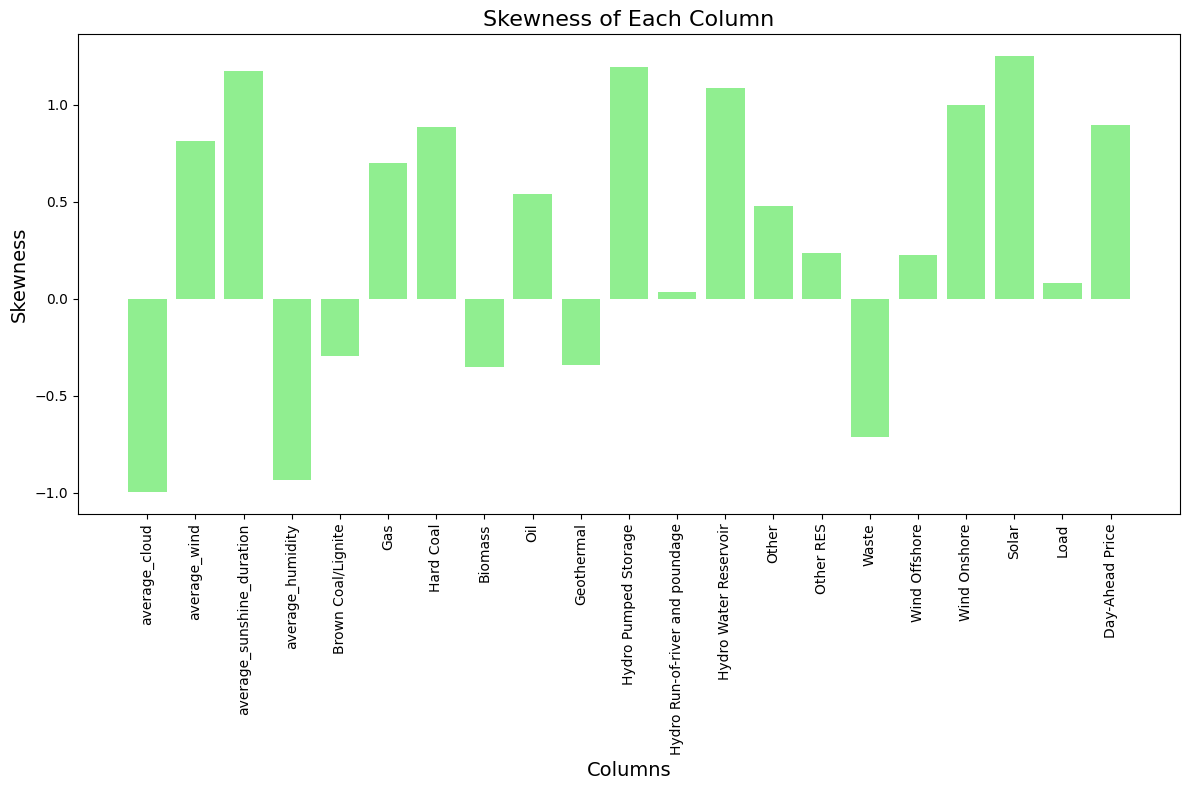

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(skewness.index, skewness.values, color='lightgreen')

plt.xlabel('Columns', fontsize=14)
plt.ylabel('Skewness', fontsize=14)
plt.title('Skewness of Each Column', fontsize=16)
plt.xticks(rotation=90)  # Rotate column names for better readability

# Show the plot
plt.tight_layout()
plt.show()
